# microQC
## Micro Signal Quality Control
#### Reads Neuralynx (NLX) and Blackrock (BR) files, then saves an image of the plotted raw time series and RMS for each channel.

In [1]:
import pandas as pd; pd.set_option('display.max_columns', 30); pd.set_option('display.max_rows', 100)
import numpy as np
import sys
import os
import os.path as op
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.ticker import MaxNLocator
%matplotlib inline
from copy import copy
import re
import glob

sys.path.append('/Volumes/data/ImagingData/BIDS/code/microqc/modules')

# new for loading .mat and .edf
from scipy import io # io.loadmat loads <matlab 7.3 .mat files as dicts
from scipy.signal import decimate
import mat73 # this loads newer .mat files as dicts
import neuralynx_io as nlx
import neo
import warnings
import tqdm

# colors
reset = '\033[0m'
red = '\033[91m'
green = '\033[92m'
yellow = '\033[93m'
blue = '\033[94m'
pink = '\033[95m'
teal = '\033[96m'
grey = '\033[97m'


%load_ext autoreload
%autoreload
from general import *

## Load Data

In [2]:
sub = input('Enter subject ID nunmber:' )
print('\nSubject ID: \t\t  ' + teal + sub)
sub = 'sub-'+sub
print(reset + 'Full Subject ID: \t  ' + teal + sub + grey + '\nIf incorrect, re-run previous cell')

bids = ('/Volumes/data/ImagingData/BIDS')
bids_sub = op.join(bids,sub) 
derivs = op.join(bids,'derivatives')
code = op.join(bids,'code')
microqc_code = op.join(code,'microqc')
microqc = op.join(derivs,'microqc')
ieeg = f'{bids}/{sub}/ieeg'

# mkdir ieeg, if not exist
if not op.exists(ieeg):
    os.mkdir(ieeg)

# check dirs exist
print(pink + '\nChecking BIDS and subdirectories')
dirs = {'bids': bids, 'bidsub': bids_sub, 'derivs': derivs, 'code': code, 'qc_code': microqc_code, 'microqc': microqc, 'ieeg': ieeg}
noexist =  "path doesn't exist, double check and re-run cell"
for dirname, path in dirs.items():
    if op.exists(path):
        print(teal + dirname + '\t= ' + path + reset)
    else:
        print(red + dirname + '\t= ' + noexist)
        
# check if derivs/microQC/sub dir exists
microqc_sub = op.join(microqc,sub)
if op.exists(microqc_sub):
        print(teal + 'microqc_sub\t= ' + microqc_sub + reset)
else:
    print(yellow + 'microqc_sub\t= Does not exist, creating directory...')
    os.mkdir(microqc_sub)
    print(teal + 'microqc_sub\t= ' + microqc_sub + reset)

Enter subject ID nunmber: 564



Subject ID: 		  564
Full Subject ID: 	  sub-564
If incorrect, re-run previous cell

Checking BIDS and subdirectories
bids	= /Volumes/data/ImagingData/BIDS
bidsub	= /Volumes/data/ImagingData/BIDS/sub-564
derivs	= /Volumes/data/ImagingData/BIDS/derivatives
code	= /Volumes/data/ImagingData/BIDS/code
qc_code	= /Volumes/data/ImagingData/BIDS/code/microqc
microqc	= /Volumes/data/ImagingData/BIDS/derivatives/microqc
ieeg	= /Volumes/data/ImagingData/BIDS/sub-564/ieeg
microqc_sub	= /Volumes/data/ImagingData/BIDS/derivatives/microqc/sub-564


## Enter Raw Data Path

In [6]:
# get path from user
print(green + 'Enter path to raw data:' + grey + '\nExample: /Volumes/data/NLData/D505/EXP6_ClosedLoop/2019-03-11_22-45-21/\n')
path = input()
if op.exists(path):
    print(teal + '\ndata \t= ' + path + reset)
else:
    noexist =  "path doesn't exist, double check and re-run cell"
    print(red + 'data \t= ' + noexist)
    
# get experiment and check if microQC/sub/exp exists
if re.search('NLData',path):
    record_sys = 'NLX'
    exp = path.split('/')[5]
    print(teal + 'system \t= ' + record_sys)    
    print(teal + 'exp_name \t= ' + exp)
elif re.search('BRData',path):
    # get elec names, since BR files have generic channel names
    print(green + '\nEnter micro electrode names in order:' + grey + '\nExample: REC RAH ROPR-MI ...')
    elec_names = {}
    electrode_list = input().split()
    for i, name in enumerate(electrode_list, start=1):
        elec_names[i] = name
    print(pink + 'Electrode names:')
    print(elec_names)
    
    record_sys = 'BR'
    exp = path.split('/')[6]
    print(teal + 'system \t= ' + record_sys)    
    print(teal + 'exp_name \t= ' + exp)
else:
    print(red + 'Cannot determine recording system from path name')
    
# add check for correct subject match to previous cell to that in path name
#if record_sys == 'NLX':
#elif record_sys == 'BR'    
    
exp_dir = op.join(microqc_sub,exp)
if op.exists(exp_dir):
        print(teal + 'exp_dir \t= ' + exp_dir + reset)
else:
    print(yellow + 'exp_dir \t= Does not exist, creating directory...')
    os.mkdir(exp_dir)
    print(teal + 'exp_dir \t= ' + exp_dir + reset)
print(reset + grey + '\nIf incorrect, re-run cell')

print(pink + f'\n{sub}\n{exp}' + grey)
files_list = os.listdir(path)

# Create a list of files in directory along with the size
size_of_file = [
    (f,os.stat(os.path.join(path, f)).st_size)
    for f in files_list
]

# Iterate over list of files along with size and print them one by one.
for f,s in size_of_file:
    print("{} : {}MB ".format(f, round(s/(1024*1024),3)))

Enter path to raw data:
Example: /Volumes/data/NLData/D505/EXP6_ClosedLoop/2019-03-11_22-45-21/



 /Volumes/data/BRData/Ripple/sub-564/sub-564_exp-ripple_run-2



data 	= /Volumes/data/BRData/Ripple/sub-564/sub-564_exp-ripple_run-2

Enter micro electrode names in order:
Example: REC RAH ROPR-MI ...


Electrode names:
{}
system 	= BR
exp_name 	= sub-564_exp-ripple_run-2
exp_dir 	= Does not exist, creating directory...
exp_dir 	= /Volumes/data/ImagingData/BIDS/derivatives/microqc/sub-564/sub-564_exp-ripple_run-2

If incorrect, re-run cell

sub-564
sub-564_exp-ripple_run-2
sub-564_task-rest_run-2.ano : 50.041MB 
sub-564_task-rest_run-2.ns5 : 466.517MB 
sub-564_task-rest_run-2.edf : 726.353MB 
sub-564_task-rest_run-2.1.edf : 516.907MB 
sub-564_task-rest_run-2.nev : 188.235MB 
sub-564_task-rest_run-2.nf3 : 62.21MB 
sub-564_task-rest_run-2.ns2 : 15.559MB 


## Plot Raw Data and RMS (NLX or BR)

Loading BR `.ns5`...

BR_ns5 = /Volumes/data/BRData/Ripple/sub-564/sub-564_exp-ripple_run-2/sub-564_task-rest_run-2.ns5


Processing channels:   0%|          | 0/128 [00:00<?, ?channel/s]/Users/ajrangel/anaconda3/envs/john_env_2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ajrangel/anaconda3/envs/john_env_2/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/Users/ajrangel/anaconda3/envs/john_env_2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ajrangel/anaconda3/envs/john_env_2/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/Users/ajrangel/anaconda3/envs/john_env_2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=


Rendering plot...


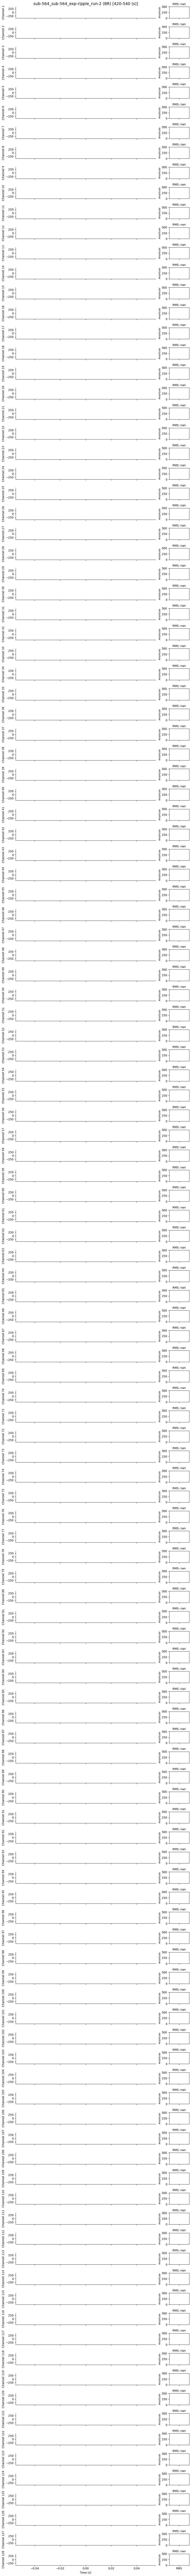

CPU times: user 57.3 s, sys: 2.62 s, total: 59.9 s
Wall time: 57.7 s


In [7]:
%%time
plot_window = [420, 540]  # in seconds

if record_sys == 'NLX':
    # get micros path
    micros_path = glob.glob(path + '/G*.ncs')
    num_channels = len(micros_path)
    micro_elecs = int(num_channels / 8)

    # create channel dict
    channel_names = {}
    for micro in micros_path:
        file = op.splitext(op.basename(micro))[0]
        channel = file.split('/')[-1]
        channel_index = len(channel_names)
        channel_names[channel_index] = channel

    electrode_names = set()
    for v in channel_names.values():
        match = re.match(r'G([A-D][1-4])-(.*)', v)
        if match:
            electrode_name = match.group(2)
            electrode_names.add(electrode_name)
    elec_names = sorted(electrode_names)
    print(f'Electrode Names\t= {elec_names}')

    print(f'\nChannels\t= {num_channels}')
    print(f'Electrodes\t= {micro_elecs}')
    # for k, v in channel_names.items():
    #     print(f'{k} : {v}')

    # load and plot NLX micros
    warnings.filterwarnings("ignore", message="Unable to parse")
    warnings.filterwarnings("ignore", message="Invalid samples in one or more records")

    downsample = 1000
    t_start = int(plot_window[0] * downsample)
    t_stop = int(plot_window[1] * downsample)

    # create figure
    fig, axs = plt.subplots(num_channels, 2, sharex='col', figsize=(12, num_channels * 1),
                            gridspec_kw={'width_ratios': [7, 1]})  # Adjust width_ratios for subplot widths
    axs[0, 0].set_title(f'{sub}_{exp} ({record_sys}) [{plot_window[0]}-{plot_window[1]} (s)]', fontsize=14)

    for i, micro in enumerate(tqdm.tqdm(micros_path, desc='Processing channels', unit='channel')):
        # load micro channel
        micro_data = nlx.load_ncs(micro)
        # get data to plot
        channel_data = decimate(micro_data['data'], int(32000 / downsample))
        channel_data = channel_data[t_start:t_stop]

        # plot raw data
        axs[i, 0].plot(channel_data)
        axs[i, 0].spines['right'].set_visible(False)
        axs[i, 0].spines['top'].set_visible(False)
        axs[i, 0].set_ylabel(channel_names[i], fontsize=10)
        axs[i, 0].set_ylim([-400, 400])

        # compute and plot RMS
        rms = np.sqrt(np.mean(channel_data ** 2))

        axs[i, 1].bar(['RMS'], [rms], color='gold')
        axs[i, 1].set_ylabel('Amplitude', fontsize=8)
        axs[i, 1].set_ylim([0, 500])
        axs[i, 1].set_title(f'RMS: {rms:.2f}', fontsize=10)

    print(yellow + '\nRendering plot...')
    
    # create x-axis on bottom channels
    # x_interval = 30000
    # Calculate suitable x_interval based on plot window duration
    plot_duration = plot_window[1] - plot_window[0]
    if plot_duration <= 20:
        x_interval = 2
    elif plot_duration <= 60:
        x_interval = 5
    elif plot_duration <= 120:
        x_interval = 10
    else:
        x_interval = 20
    
    axs[-1, 0].set_xlabel('Time (s)')
    xticks = np.arange(0, ((t_stop - t_start) + 1), x_interval * downsample)
    xlabels = np.arange(int(t_start / downsample), int((t_stop / downsample) + 1), x_interval)
    axs[-1, 0].set_xticks(xticks)
    axs[-1, 0].set_xticklabels(xlabels)

    # remove empty subplot(s) if the number of channels is not a multiple of 2
    if num_channels % 2 != 0:
        fig.delaxes(axs[num_channels - 1, 1])

    plt.tight_layout(rect=[0, 0, 0.8, 1])  # Adjust the rectangle to make room for wider time series plots

    # save the figure with raw timeseries subplots and RMS plots
    fig.savefig(f'{exp_dir}/{sub}_{exp}_{plot_window[0]}-{plot_window[1]}_signal-raw_sys-{record_sys}_microQC.png', bbox_inches='tight', dpi=200)

    plt.show()

elif record_sys == 'BR':
    # load and plot BR micros
    ns5 = glob.glob(path + '/*.ns5')[0]
    print(yellow + 'Loading BR `.ns5`...')
    print('\nBR_ns5 = ' + ns5)

    # Load the data
    reader = neo.io.BlackrockIO(filename=ns5)
    block = reader.read_block(lazy=False)
    segment = block.segments[0]

    # Get the micro channel with a 30 kHz sampling rate
    micro_channel = block.segments[0].analogsignals[1]

    # Set the time range to plot
    t_start = plot_window[0]  # in seconds
    t_stop = plot_window[1]  #

    # Convert the time range to sample indices
    start_idx = int(t_start * micro_channel.sampling_rate)
    stop_idx = int(t_stop * micro_channel.sampling_rate)

    # Extract the data for the specified time range
    data = micro_channel.magnitude[start_idx:stop_idx, :]

    # Get the number of channels
    num_channels = data.shape[1]

    # Create subplots for each channel
    fig, axs = plt.subplots(num_channels, 2, sharex='col', figsize=(12, num_channels * 1),
                            gridspec_kw={'width_ratios': [7, 1]})  # Adjust width_ratios for subplot widths
    axs[0, 0].set_title(f'{sub}_{exp} ({record_sys}) [{plot_window[0]}-{plot_window[1]} (s)]', fontsize=14)

    # Plot the data for each channel
    for channel in tqdm.tqdm(range(num_channels), desc='Processing channels', unit='channel'):
        channel_data = data[:, channel]

        # # map elec_names to channel for y-label
        # # Get the electrode name for the current channel
        # electrode_name = elec_names.get(channel + 1, f"Channel {channel + 1}")
        # # Set the y-label using the electrode name and channel number
        # axs[channel, 0].set_ylabel(f"{electrode_name}{channel + 1}", fontsize=10)
        
        # Plot raw data
        axs[channel, 0].plot(micro_channel.times[start_idx:stop_idx], channel_data)
        axs[channel, 0].spines['right'].set_visible(False)
        axs[channel, 0].spines['top'].set_visible(False)
        axs[channel, 0].set_ylabel(f"Channel {channel + 1}", fontsize=10)
        axs[channel, 0].set_ylim([-400, 400])

        # Compute and plot RMS
        rms = np.sqrt(np.mean(channel_data ** 2))

        axs[channel, 1].bar(['RMS'], [rms], color='gold')
        axs[channel, 1].set_ylabel('Amplitude', fontsize=8)
        axs[channel, 1].set_ylim([0, 500])
        axs[channel, 1].set_title(f'RMS: {rms:.2f}', fontsize=10)

    
    print(yellow + '\nRendering plot...')
    
    # Create x-axis on bottom channels
    axs[-1, 0].set_xlabel("Time (s)")

    # Remove empty subplot(s) if the number of channels is not a multiple of 2
    if num_channels % 2 != 0:
        fig.delaxes(axs[num_channels - 1, 1])

    plt.tight_layout(rect=[0, 0, 0.8, 1])

    # Save the figure with raw timeseries subplots and RMS plots
    fig.savefig(f'{exp_dir}/{sub}_{exp}_{plot_window[0]}-{plot_window[1]}_signal-raw_sys-{record_sys}_microQC.png',
        bbox_inches='tight', dpi=200)

    plt.show()

else:
    %%timeprint(f"Unsupported record_sys: {record_sys}. Please provide valid record_sys value.")
    

## Side-by-Side Comparison Plots